# Импорт библиотек

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import holidays
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm_notebook, tqdm
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

In [39]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [40]:
def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам MAE, MSE, RMSE, R² и MAPE.

    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """

    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")

    results = []
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        
        # Вычисление метрик регрессии
        mae = mean_absolute_error(Y, y_pred)
        mse = mean_squared_error(Y, y_pred)
        rmse = np.sqrt(mse)  # Корень из среднеквадратичной ошибки
        r2 = r2_score(Y, y_pred)
        
        # Средняя абсолютная процентная ошибка (MAPE)
        mape = np.mean(np.abs((Y - y_pred) / Y)) * 100 if np.all(Y != 0) else None

        results.append({
            'Model': name,
            'MAE': round(mae, 4),
            'MSE': round(mse, 4),
            'RMSE': round(rmse, 4),
            'R²': round(r2, 4),
            'MAPE': round(mape, 4)
        })
    
    results_df = pd.DataFrame(results)
    return results_df

# Анализ данных и обработка

In [41]:
data = pd.read_csv('data/train.csv', nrows=500000)
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                500000 non-null  object 
 1   fare_amount        500000 non-null  float64
 2   pickup_datetime    500000 non-null  object 
 3   pickup_longitude   500000 non-null  float64
 4   pickup_latitude    500000 non-null  float64
 5   dropoff_longitude  499995 non-null  float64
 6   dropoff_latitude   499995 non-null  float64
 7   passenger_count    500000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 30.5+ MB


In [43]:
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64

In [44]:
data['dropoff_longitude'] = data['dropoff_longitude'].fillna(data['dropoff_longitude'].median())
data['dropoff_latitude'] = data['dropoff_latitude'].fillna(data['dropoff_latitude'].median())

<Axes: >

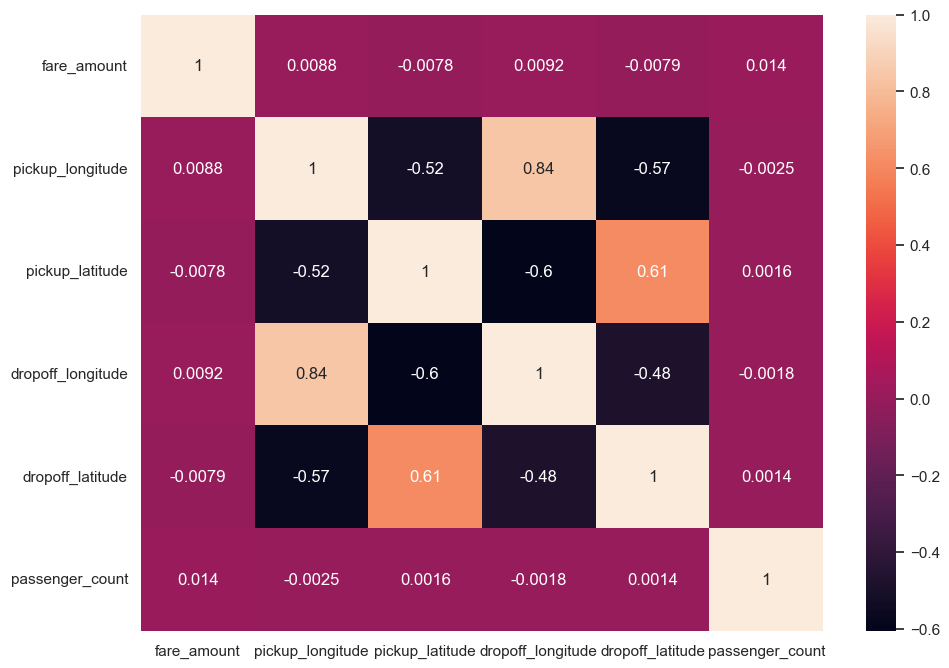

In [45]:
corr_matrix = data[data.select_dtypes(include=[np.number]).columns.to_list()].corr()

sns.set(rc={'figure.figsize': (11, 8)})

sns.heatmap(corr_matrix, annot=True)

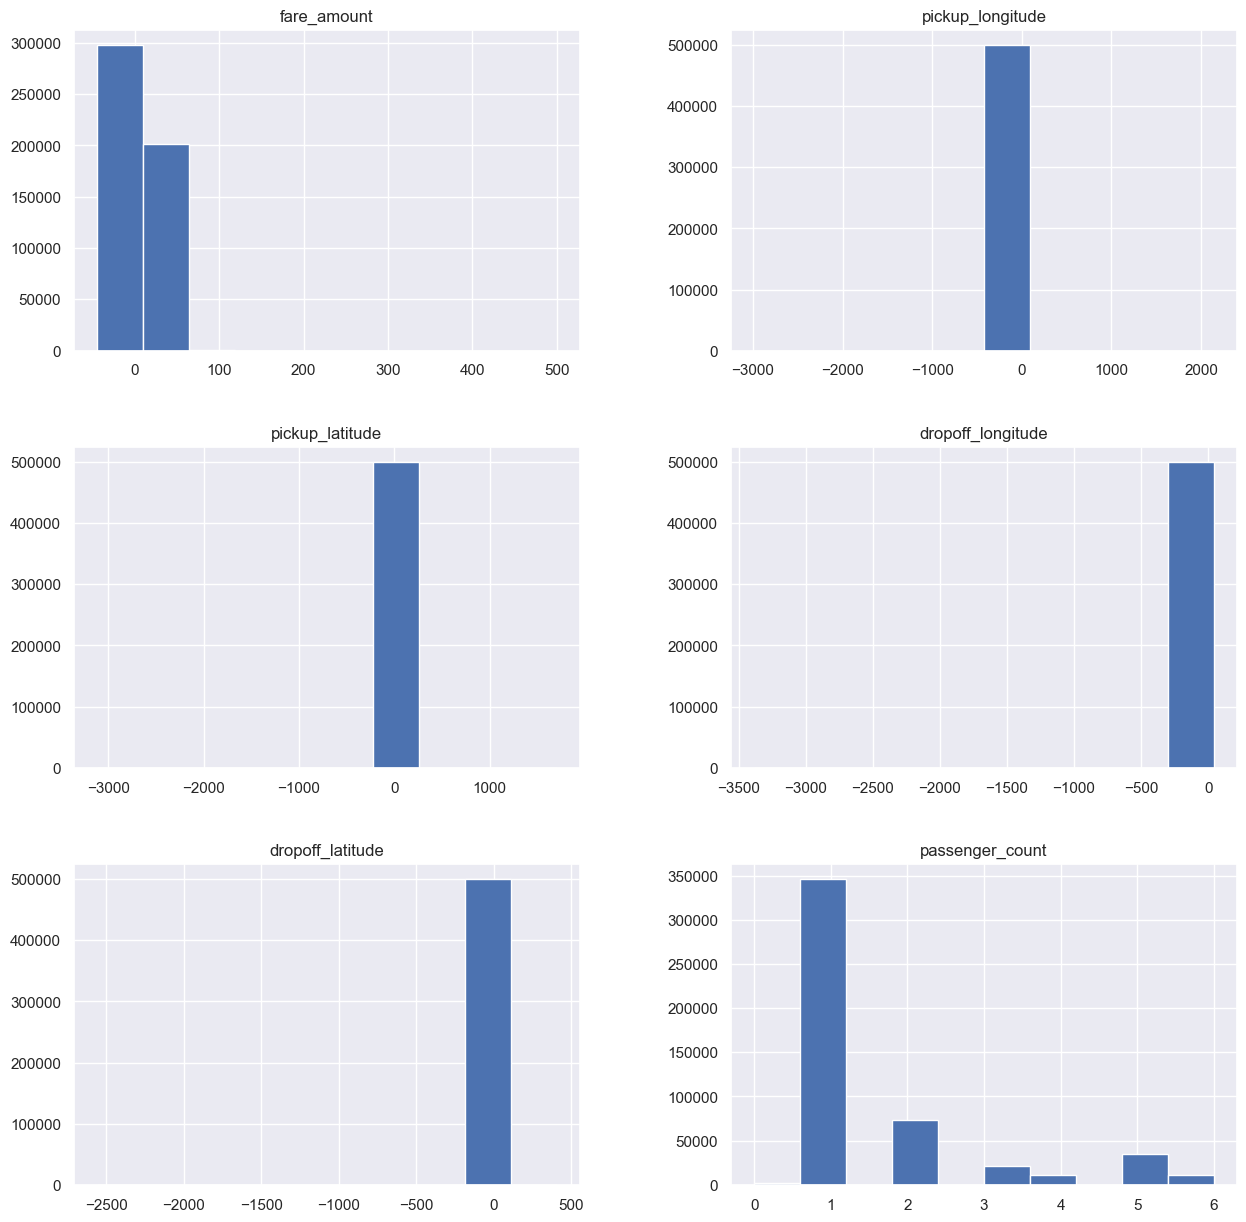

In [46]:
data.hist(figsize=(15, 15));

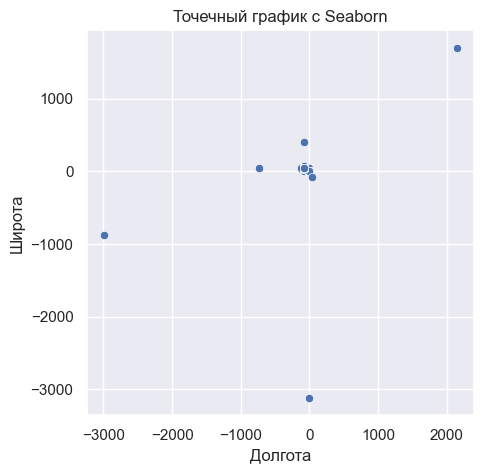

In [47]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=data)
plt.title('Точечный график с Seaborn')  # Заголовок
plt.xlabel('Долгота')  # Метка для оси X
plt.ylabel('Широта')  # Метка для оси Y
plt.show()

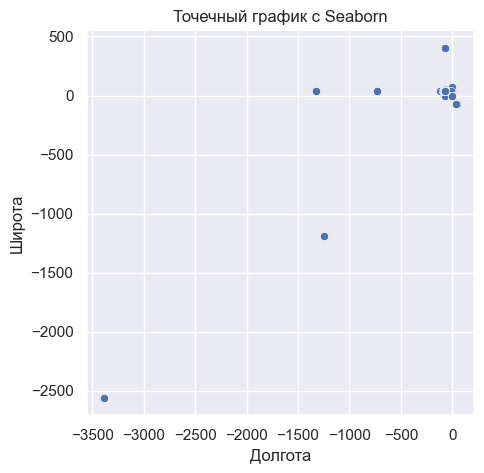

In [48]:
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=data)
plt.title('Точечный график с Seaborn')  # Заголовок
plt.xlabel('Долгота')  # Метка для оси X
plt.ylabel('Широта')  # Метка для оси Y
plt.show()

Data points within threshold: 490181


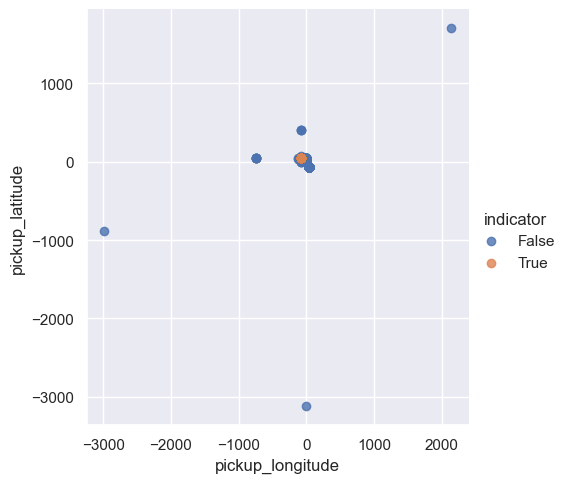

In [49]:
sns.set()
local_coord = [-73.9855, 40.7580]  # точка, относительно которой определяем порог дистанции
euc_dist_th = 2  # порог расстояния

# Вычисляем евклидово расстояние
euclid_distance = data[['pickup_longitude', 'pickup_latitude']].apply(
    lambda x: np.sqrt((x['pickup_longitude'] - local_coord[0]) ** 2 + (x['pickup_latitude'] - local_coord[1]) ** 2), axis=1
)

# Определяем, входит ли точка в порог
indicator = pd.Series(euclid_distance <= euc_dist_th, name='indicator')

print("Data points within threshold:", sum(indicator))

# Визуализация региона
# Заменяем аргументы для lmplot
sns.lmplot(
    x='pickup_longitude', y='pickup_latitude', data=pd.concat([data, indicator], axis=1),
    hue='indicator', scatter_kws={'marker': '.'}, fit_reg=False, height=5
)

Data points within threshold: 490170


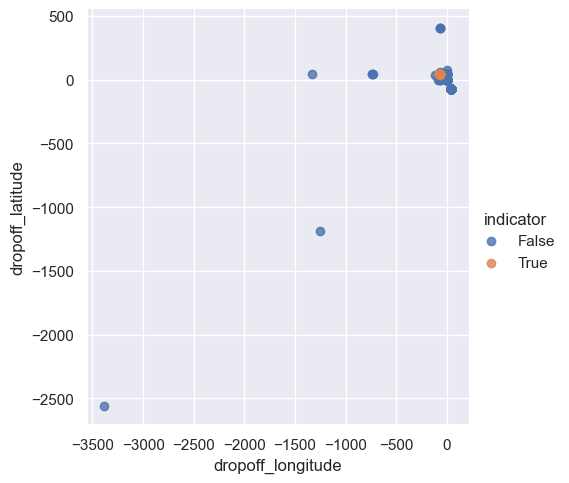

In [50]:
sns.set()
local_coord = [-73.9855, 40.7580]  # точка, относительно которой определяем порог дистанции
euc_dist_th = 2  # порог расстояния

# Вычисляем евклидово расстояние
euclid_distance = data[['dropoff_longitude', 'dropoff_latitude']].apply(
    lambda x: np.sqrt((x['dropoff_longitude'] - local_coord[0]) ** 2 + (x['dropoff_latitude'] - local_coord[1]) ** 2), axis=1
)

# Определяем, входит ли точка в порог
indicator = pd.Series(euclid_distance <= euc_dist_th, name='indicator')

print("Data points within threshold:", sum(indicator))

# Визуализация региона
# Заменяем аргументы для lmplot
sns.lmplot(
    x='dropoff_longitude', y='dropoff_latitude', data=pd.concat([data, indicator], axis=1),
    hue='indicator', scatter_kws={'marker': '.'}, fit_reg=False, height=5
)

# Признаки

In [51]:
def add_holiday_feature(df, timestamp_col, country='USA'):
    """
    Добавляет бинарный признак праздников в DataFrame на основе заданной страны.

    Параметры:
    df (pd.DataFrame): DataFrame с колонкой, содержащей метки времени.
    timestamp_col (str): Название колонки с метками времени.
    country (str): Код страны (например, 'US' для США, 'RU' для России).

    Возвращает:
    pd.DataFrame: DataFrame с добавленной колонкой 'is_holiday' (1 - праздник, 0 - не праздник).
    """
    # Приводим колонку меток времени к формату даты (игнорируя время)
    df['date_only'] = pd.to_datetime(df[timestamp_col]).dt.date
    
    # Создаем объект праздников для указанной страны и приводим его к формату дат
    country_holidays = [d for d in holidays.CountryHoliday(country, years=range(2000, 2024))]
    
    # Определяем, является ли дата праздником: 1 для праздника, 0 для обычного дня
    df['is_holiday'] = df['date_only'].isin(country_holidays).astype(int)
    
    # Удаляем временную колонку 'date_only'
    df.drop(columns='date_only', inplace=True)
    
    return df


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Рассчитывает расстояние по сфере (в километрах) между двумя точками с известной широтой и долготой
    с использованием формулы Хаверсина.
    
    Параметры:
    lat1, lon1 (float): Координаты первой точки (в градусах).
    lat2, lon2 (float): Координаты второй точки (в градусах).
    
    Возвращает:
    float: Расстояние между точками в километрах.
    """
    # Преобразуем градусы в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Разницы в координатах
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Применяем формулу Хаверсина
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Радиус Земли в километрах и вычисление расстояния
    return 6371.0 * c


def calculate_relative_coordinates_flat(df, lat_col, lon_col, center_lat, center_lon):
    """
    Пересчитывает координаты относительно центра (center_lat, center_lon) в километрах.
    Параметры:
    - df: DataFrame с исходными координатами
    - lat_col: имя столбца с широтой
    - lon_col: имя столбца с долготой
    - center_lat: широта центральной точки
    - center_lon: долгота центральной точки
    
    Возвращает:
    - DataFrame с новыми столбцами 'relative_lat' и 'relative_lon', представляющими относительные координаты в км.
    """
    # Коэффициент перевода градусов широты в километры
    lat_to_km = 111  # 1 градус широты примерно равен 111 км
    # Вычисляем относительные координаты для широты
    df[lat_col] = (df[lat_col] - center_lat) * lat_to_km
    # Вычисляем относительные координаты для долготы с учетом кривизны Земли
    df[lon_col] = (df[lon_col] - center_lon) * lat_to_km * np.cos(np.radians(center_lat))
    return df


def manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Рассчитывает расстояние Манхэттена между двумя точками с учетом приближенных коэффициентов для перевода широты и долготы в километры.
    Параметры:
    lat1, lon1 (float): Координаты первой точки.
    lat2, lon2 (float): Координаты второй точки.
    Возвращает:
    float: Манхэттенское расстояние между точками в километрах.
    """
    # Широта переводится в километры с коэффициентом 111
    return np.abs(lat1 - lat2) * 111 + np.abs(lon1 - lon2) * 111

In [52]:
def generate_geospatial_features(data, reference_points=None, distance_pairs=None, timestamp_col='pickup_datetime', reference_points_cols=None):
    """
    Генерирует геопространственные признаки на основе расстояний, опорных точек и временных характеристик.
    
    Параметры:
    data (pd.DataFrame): Исходный DataFrame.
    reference_points (list): Список кортежей с названиями и координатами опорных точек.
    distance_pairs (list): Список кортежей с названиями колонок для расчета расстояний.
    timestamp_col (str): Название колонки с метками времени.
    origin_lat_col, origin_lon_col (str): Названия колонок с исходными координатами для расчета до опорных точек.
    
    Возвращает:
    pd.DataFrame: DataFrame с новыми геопространственными признаками.
    """
    
    # 1. Расчет расстояний между парами координат в distance_pairs
    if distance_pairs:
        for i, (start_lon_col, start_lat_col, end_lon_col, end_lat_col) in enumerate(distance_pairs):
            # Добавляем Манхэттенское расстояние
            data[f'manhattan_distance{i}'] = manhattan_distance(data[start_lat_col], data[start_lon_col], data[end_lat_col], data[end_lon_col])
            data[f'haversine_distance{i}'] = haversine_distance(data[start_lat_col], data[start_lon_col], data[end_lat_col], data[end_lon_col])
    
    # 2. Расчет минимальных расстояний до опорных точек, если они заданы
    if reference_points and reference_points_cols:
        # Создаем пустые столбцы для минимальных расстояний
        
        # Проходим по всем опорным точкам и обновляем минимальные расстояния
        for ref_name, (ref_lat, ref_lon) in reference_points:
            for origin_lat_col, origin_lon_col in reference_points_cols:
                # Вычисляем расстояния
                manhattan_distances = manhattan_distance(data[origin_lat_col], data[origin_lon_col], ref_lat, ref_lon)
                haversine_distances = haversine_distance(data[origin_lat_col], data[origin_lon_col], ref_lat, ref_lon)

                data[f"manhattan_distance_{ref_name}_{origin_lat_col.split('_')[0]}"] = manhattan_distances
                data[f"haversine_distance_{ref_name}_{origin_lat_col.split('_')[0]}"] = haversine_distances
    
    # 3. Извлечение временных характеристик из столбца меток времени
    if timestamp_col:
        # Преобразуем в datetime для возможности извлечения временных признаков
        data[timestamp_col] = pd.to_datetime(data[timestamp_col])
        
        # Извлекаем месяц, день, день недели, час и информацию о выходных
        data['month'] = data[timestamp_col].dt.month
        data['day'] = data[timestamp_col].dt.day
        data['hour'] = data[timestamp_col].dt.hour
    
    data['abs_long_diff'] = np.abs(data.dropoff_longitude - data.pickup_longitude)
    data['abs_lat_diff'] = np.abs(data.dropoff_latitude - data.pickup_latitude)
    return data

In [53]:
reference_points = [
    # ('central_park', (40.785091, -73.968285)), ('times_square', (40.758896, -73.985130)), ('wall_street', (40.7074, -74.0113)),
    ('nyc', (40.724944, -74.001541)), ('jfk', (40.645494, -73.785937)), ('lga', (40.774071, -73.872067)), ('nla', (40.690764, -74.177721))
    # ('Тайм-Уорнер-центр', (40.76848894342591, -73.98316849703785)), ('Челси Маркет', (40.7425238481222, -74.00616691292831))
]
distance_pairs = [('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')]

# Генерация новых признаков
data = generate_geospatial_features(
    data,
    reference_points=reference_points,
    distance_pairs=distance_pairs,
    timestamp_col='pickup_datetime',
    reference_points_cols=[('dropoff_latitude', 'dropoff_longitude'), ('pickup_latitude', 'pickup_longitude')]
)

local_coord = [-73.9855, 40.7580]  # [долгота, широта] ЦЕНТР ГОРОДА
center_lon, center_lat = local_coord  # Подстановка значений
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,...,haversine_distance_lga_pickup,manhattan_distance_nla_dropoff,haversine_distance_nla_dropoff,manhattan_distance_nla_pickup,haversine_distance_nla_pickup,month,day,hour,abs_long_diff,abs_lat_diff
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.303362,1.030764,...,6.314597,39.696375,28.434536,40.400115,28.308750,6,15,17,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,11.930391,8.450134,...,13.994570,32.155923,19.557793,20.225532,13.818961,1,5,16,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2.132532,1.389525,...,9.428224,27.336747,17.064200,29.469279,18.205343,8,18,0,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,3.261846,2.799270,...,10.707374,28.136502,17.382025,25.859670,16.740975,4,21,4,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,3.018534,1.999157,...,8.114641,34.861104,21.303672,31.842570,19.641373,3,9,7,0.011440,0.015754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12+00:00,-73.978775,40.766724,-73.966072,40.758537,1,2.318710,1.404709,...,9.023109,31.015865,19.362294,30.514523,18.771610,5,7,18,0.012703,0.008186
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34+00:00,-74.002932,40.718408,-74.009442,40.710952,1,1.550226,0.994184,...,12.642999,20.919837,14.362364,22.470063,15.051048,9,13,12,0.006510,0.007456
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20+00:00,-73.983885,40.725611,-73.896482,40.700980,1,12.435774,7.859324,...,10.851671,32.351505,23.737298,25.383813,16.791683,8,25,0,0.087403,0.024631
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32+00:00,-73.974617,40.756512,-73.970184,40.764801,6,1.412144,0.994470,...,8.854512,31.254681,19.329023,29.842537,18.611715,1,12,12,0.004433,0.008289


<Axes: >

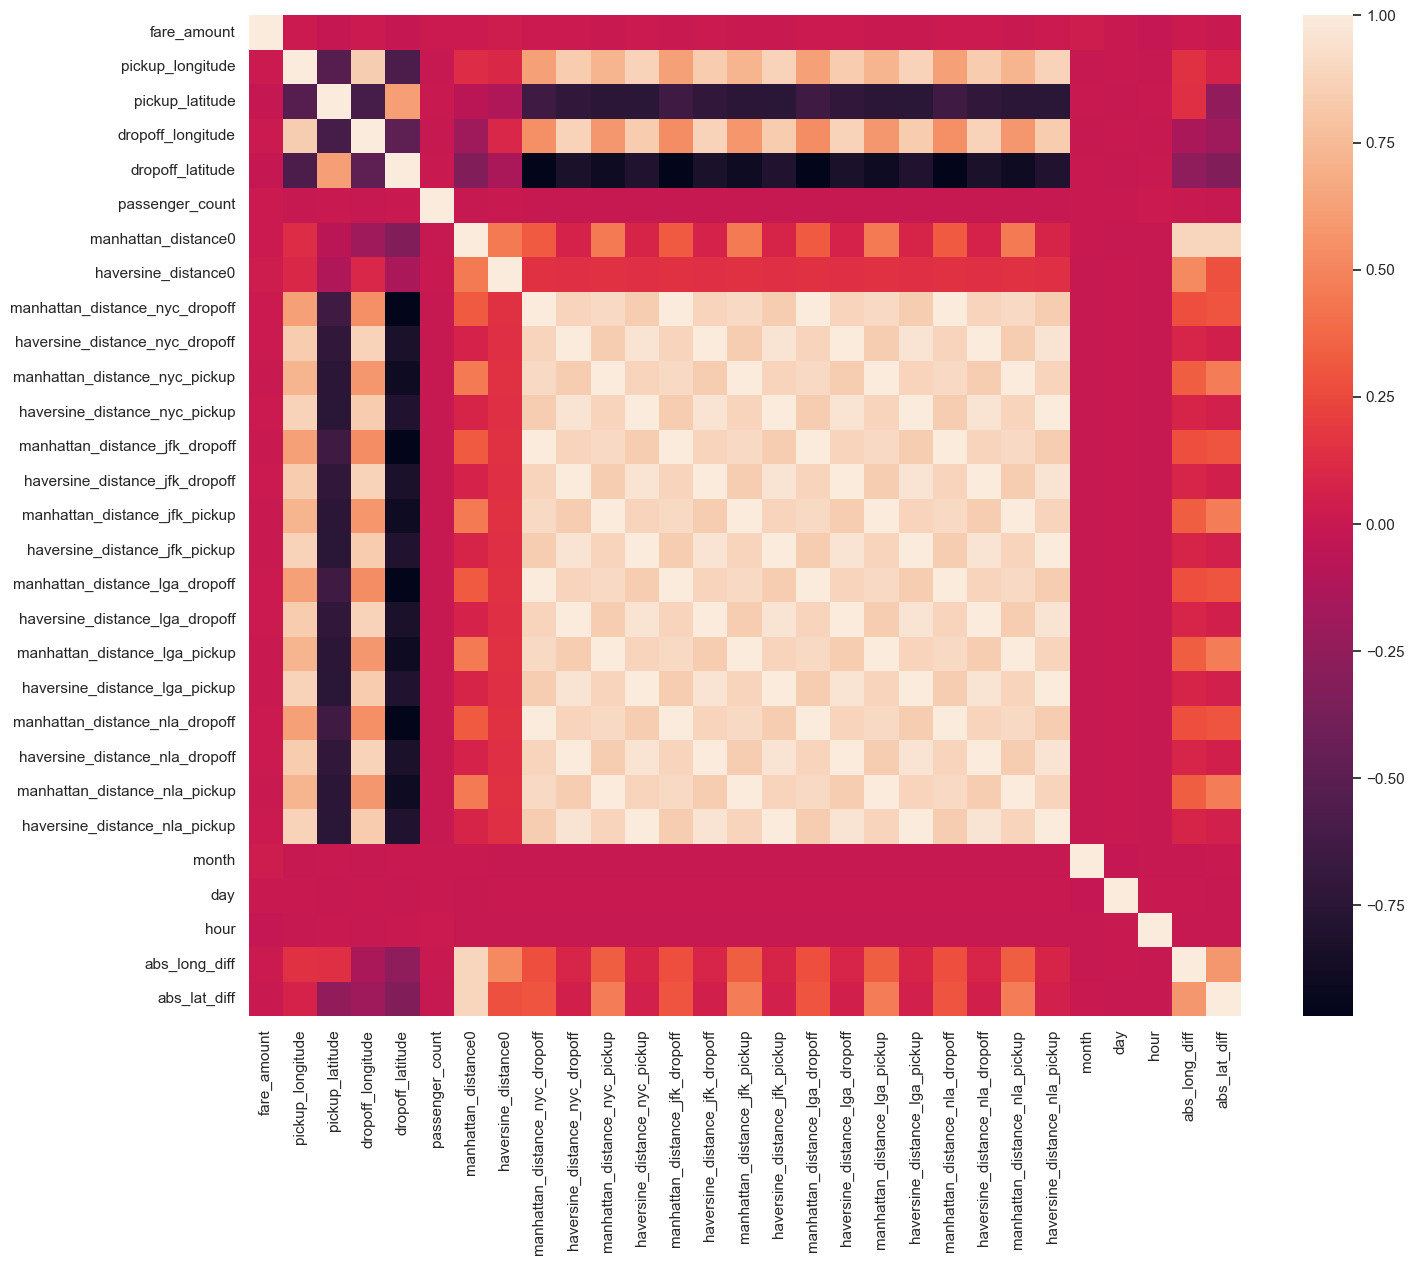

In [54]:
corr_matrix = data[data.select_dtypes(include=[np.number]).columns.to_list()]

sns.set(rc={'figure.figsize': (16, 13)})

sns.heatmap(corr_matrix.corr(), annot=False)

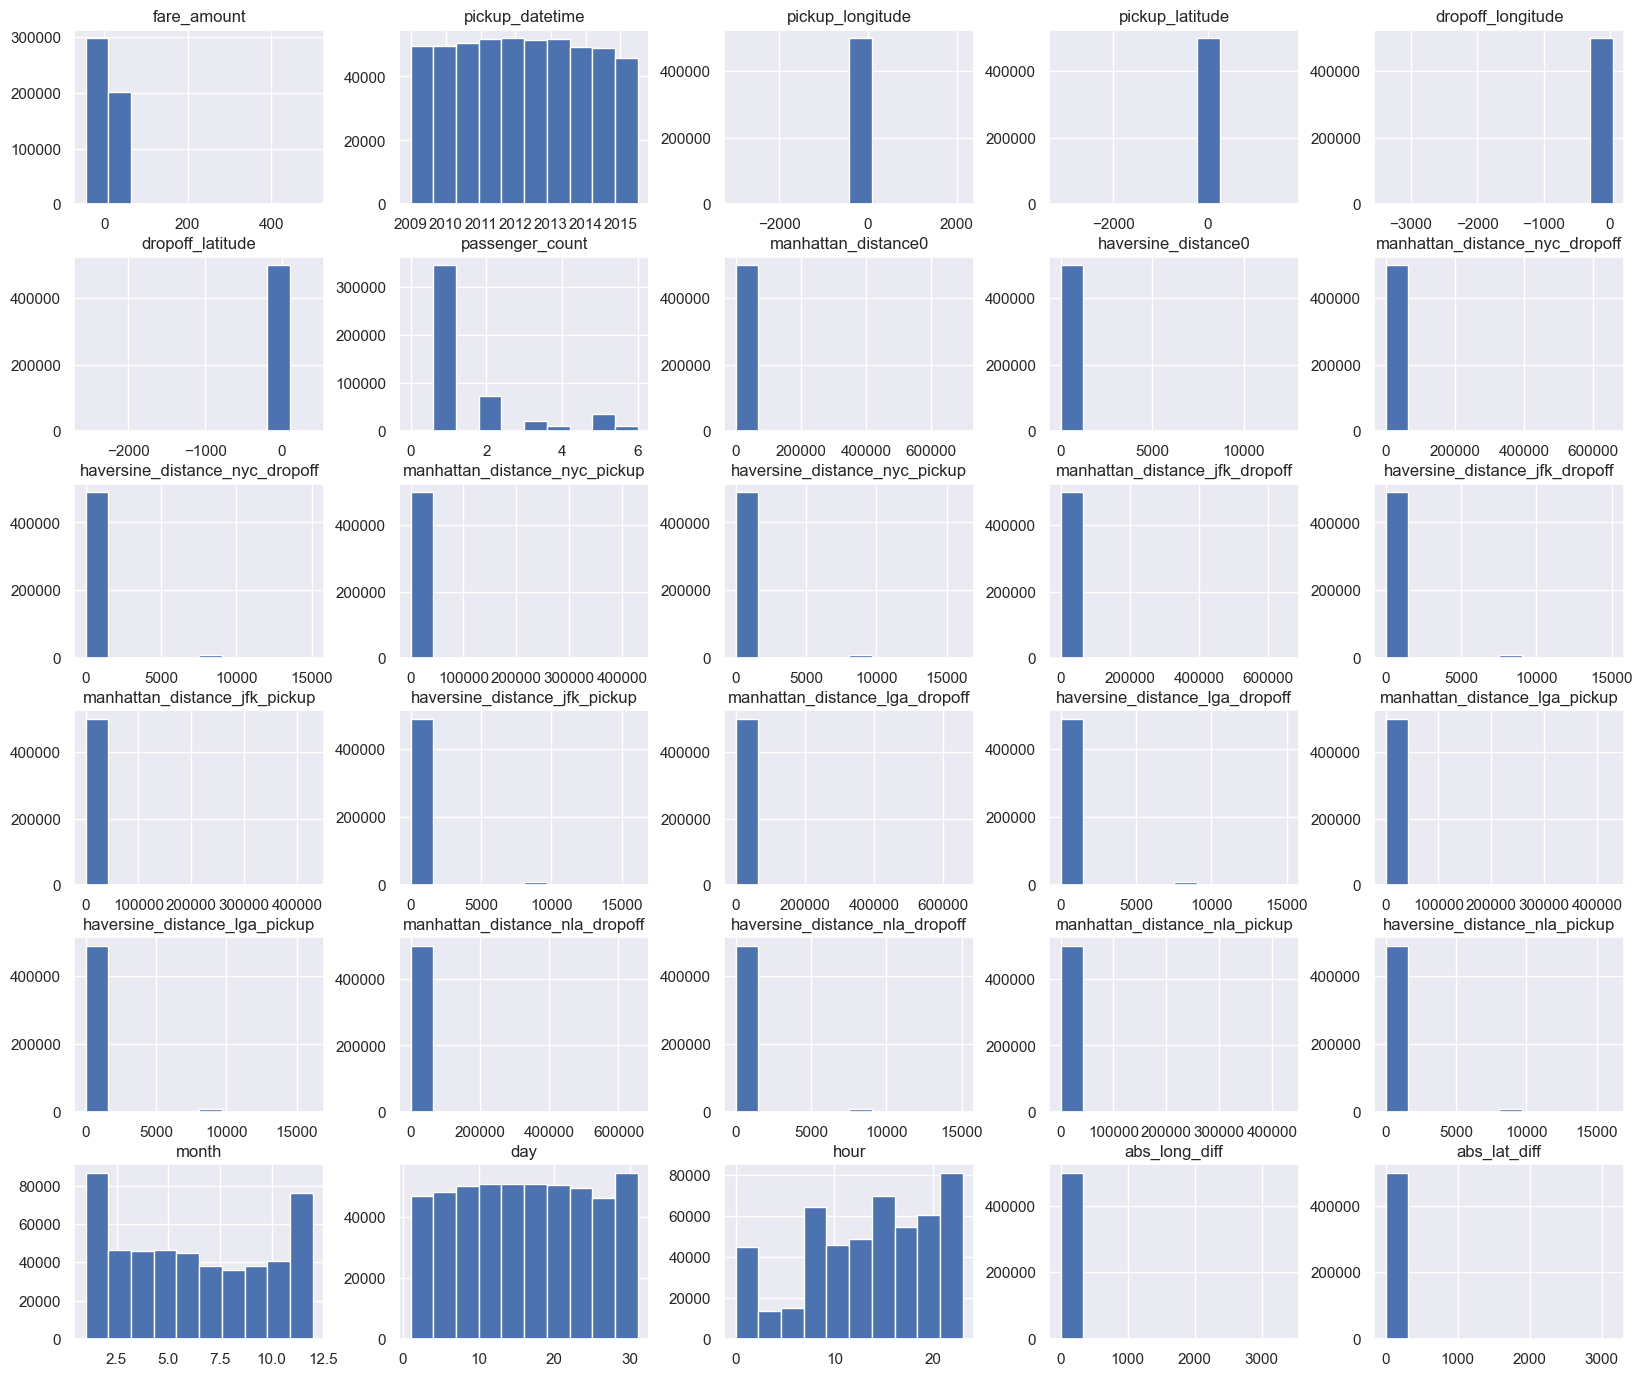

In [55]:
data.hist(figsize=(20, 17));

In [56]:
data = data[
    (data['pickup_longitude'] >= -74.5) & (data['pickup_longitude'] <= -72) & (data['pickup_latitude'] <= 41) & (data['pickup_latitude'] >= 40) &
    (data['dropoff_longitude'] >= -74.5) & (data['dropoff_longitude'] <= -72) & (data['dropoff_latitude'] <= 41) & (data['dropoff_latitude'] >= 40) &
    (data['fare_amount'] > 0) & (0 < data['passenger_count']) & (data['passenger_count'] <= 6)
]
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,...,haversine_distance_lga_pickup,manhattan_distance_nla_dropoff,haversine_distance_nla_dropoff,manhattan_distance_nla_pickup,haversine_distance_nla_pickup,month,day,hour,abs_long_diff,abs_lat_diff
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.303362,1.030764,...,6.314597,39.696375,28.434536,40.400115,28.308750,6,15,17,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,11.930391,8.450134,...,13.994570,32.155923,19.557793,20.225532,13.818961,1,5,16,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2.132532,1.389525,...,9.428224,27.336747,17.064200,29.469279,18.205343,8,18,0,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,3.261846,2.799270,...,10.707374,28.136502,17.382025,25.859670,16.740975,4,21,4,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,3.018534,1.999157,...,8.114641,34.861104,21.303672,31.842570,19.641373,3,9,7,0.011440,0.015754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12+00:00,-73.978775,40.766724,-73.966072,40.758537,1,2.318710,1.404709,...,9.023109,31.015865,19.362294,30.514523,18.771610,5,7,18,0.012703,0.008186
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34+00:00,-74.002932,40.718408,-74.009442,40.710952,1,1.550226,0.994184,...,12.642999,20.919837,14.362364,22.470063,15.051048,9,13,12,0.006510,0.007456
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20+00:00,-73.983885,40.725611,-73.896482,40.700980,1,12.435774,7.859324,...,10.851671,32.351505,23.737298,25.383813,16.791683,8,25,0,0.087403,0.024631
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32+00:00,-73.974617,40.756512,-73.970184,40.764801,6,1.412144,0.994470,...,8.854512,31.254681,19.329023,29.842537,18.611715,1,12,12,0.004433,0.008289


<Axes: >

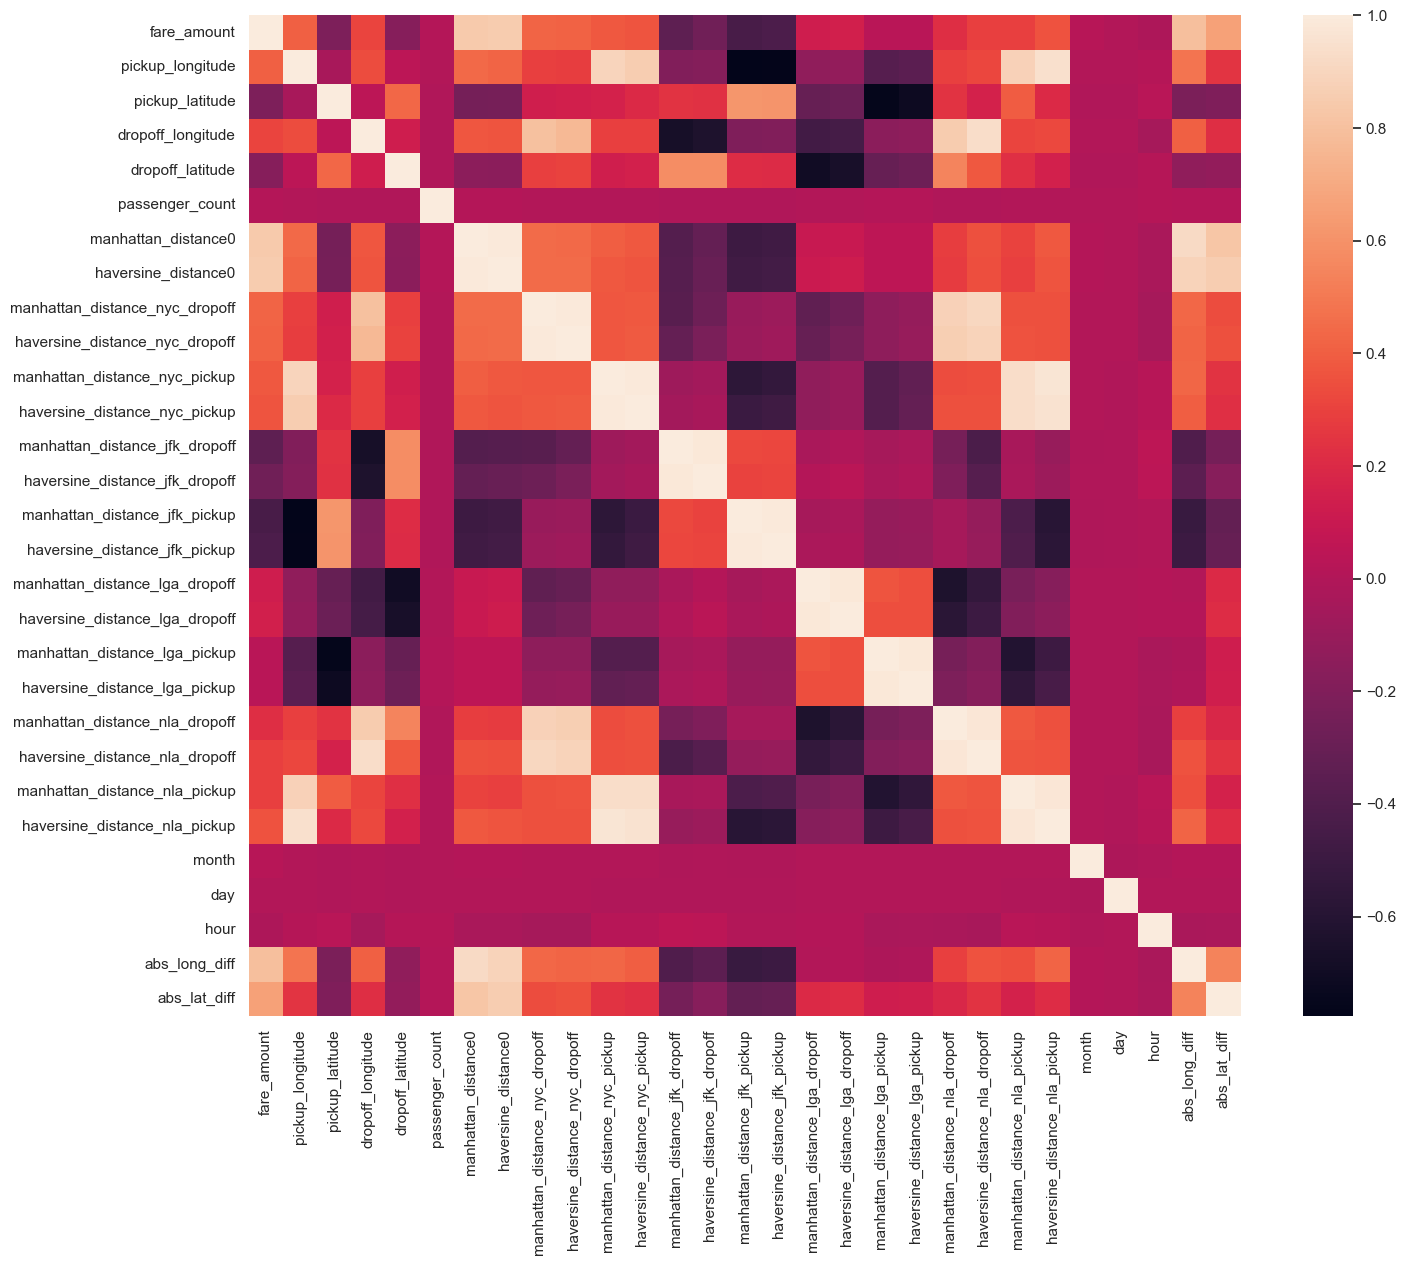

In [57]:
corr_matrix = data[data.select_dtypes(include=[np.number]).columns.to_list()]

sns.set(rc={'figure.figsize': (16, 13)})

sns.heatmap(corr_matrix.corr(), annot=False)

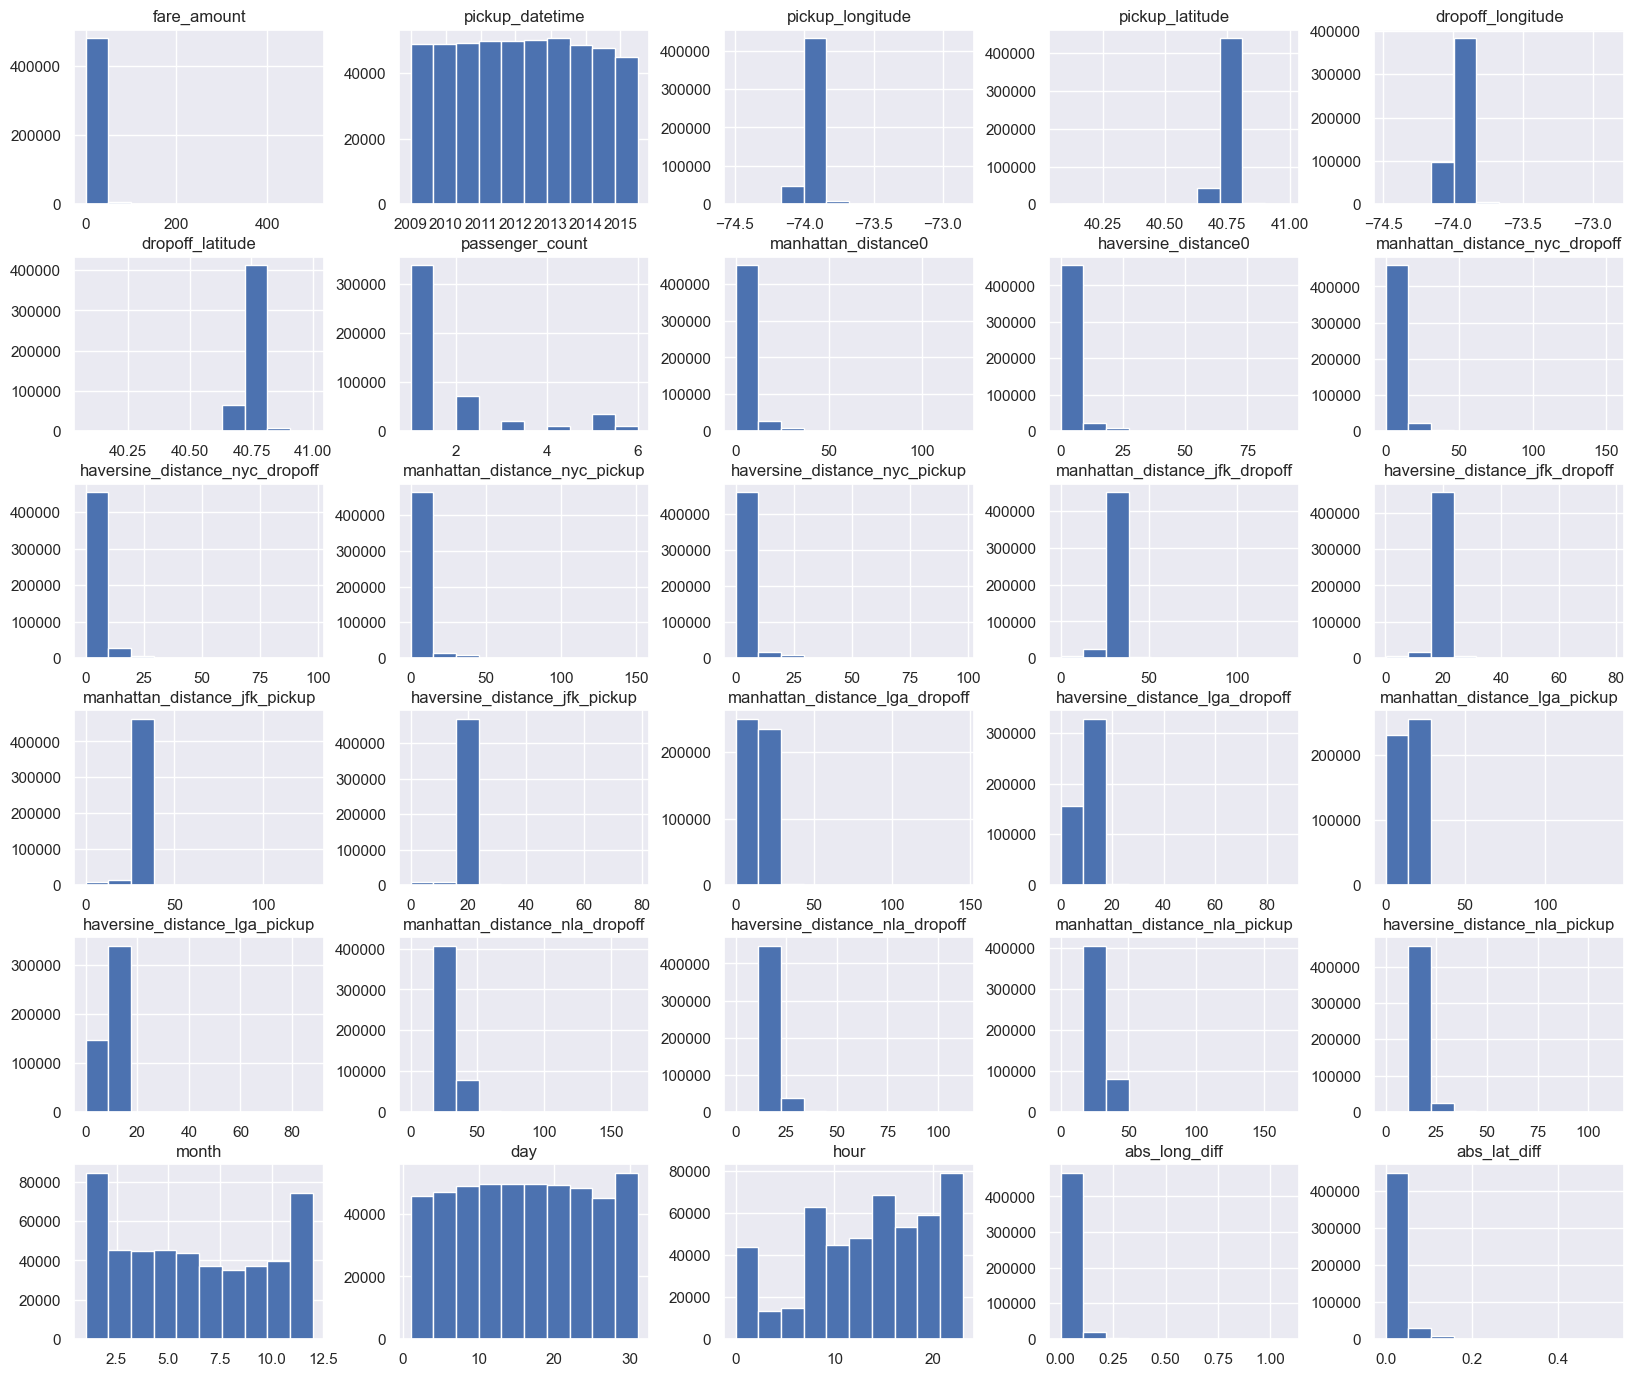

In [58]:
data.hist(figsize=(20, 17));

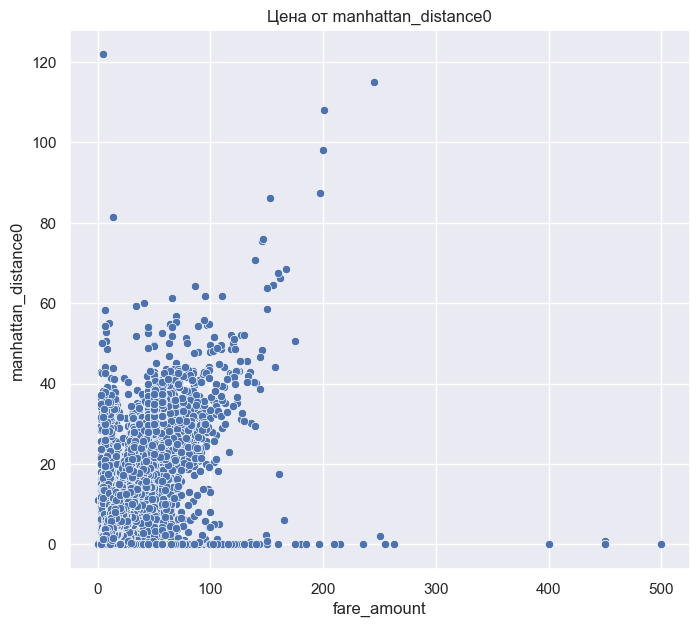

In [59]:
sns.set(rc={'figure.figsize': (8, 7)})
sns.scatterplot(x='fare_amount', y='manhattan_distance0', data=data)
plt.title('Цена от manhattan_distance0')  # Заголовок
plt.xlabel('fare_amount')  # Метка для оси X
plt.ylabel('manhattan_distance0')  # Метка для оси Y
plt.show()

Data points within threshold: 479533


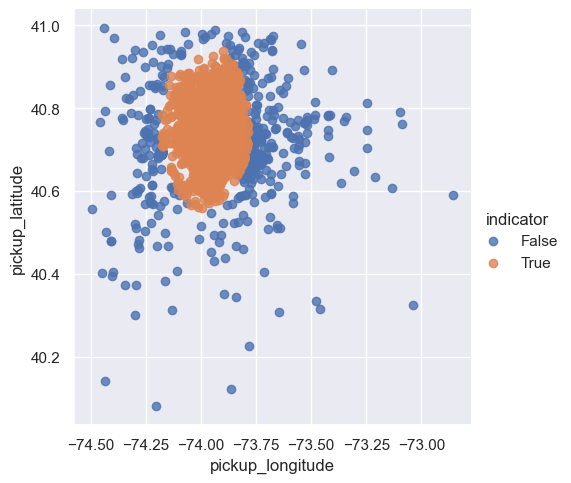

In [60]:
sns.set()
local_coord = [-73.9855, 40.7580]  # точка, относительно которой определяем порог дистанции
euc_dist_th = 0.2  # порог расстояния

# Вычисляем евклидово расстояние
euclid_distance = data[['pickup_longitude', 'pickup_latitude']].apply(
    lambda x: np.sqrt((x['pickup_longitude'] - local_coord[0]) ** 2 + (x['pickup_latitude'] - local_coord[1]) ** 2), axis=1
)

# Определяем, входит ли точка в порог
indicator = pd.Series(euclid_distance <= euc_dist_th, name='indicator')

print("Data points within threshold:", sum(indicator))

# Визуализация региона
# Заменяем аргументы для lmplot
sns.lmplot(
    x='pickup_longitude', y='pickup_latitude', data=pd.concat([data, indicator], axis=1),
    hue='indicator', scatter_kws={'marker': '.'}, fit_reg=False, height=5
)

Data points within threshold: 486945


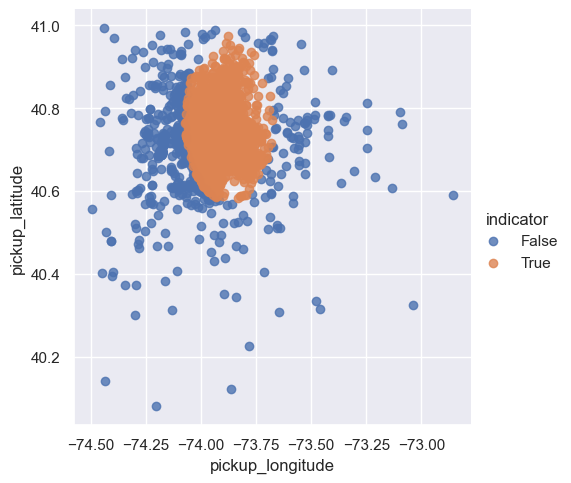

In [61]:
sns.set()
local_coord = [-73.872067, 40.774071]  # точка, относительно которой определяем порог дистанции
euc_dist_th = 0.2  # порог расстояния

# Вычисляем евклидово расстояние
euclid_distance = data[['pickup_longitude', 'pickup_latitude']].apply(
    lambda x: np.sqrt((x['pickup_longitude'] - local_coord[0]) ** 2 + (x['pickup_latitude'] - local_coord[1]) ** 2), axis=1
)

# Определяем, входит ли точка в порог
indicator = pd.Series(euclid_distance <= euc_dist_th, name='indicator')

print("Data points within threshold:", sum(indicator))

# Визуализация региона
# Заменяем аргументы для lmplot
sns.lmplot(
    x='pickup_longitude', y='pickup_latitude', data=pd.concat([data, indicator], axis=1),
    hue='indicator', scatter_kws={'marker': '.'}, fit_reg=False, height=5
)

In [62]:
data.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'manhattan_distance0', 'haversine_distance0',
       'manhattan_distance_nyc_dropoff', 'haversine_distance_nyc_dropoff',
       'manhattan_distance_nyc_pickup', 'haversine_distance_nyc_pickup',
       'manhattan_distance_jfk_dropoff', 'haversine_distance_jfk_dropoff',
       'manhattan_distance_jfk_pickup', 'haversine_distance_jfk_pickup',
       'manhattan_distance_lga_dropoff', 'haversine_distance_lga_dropoff',
       'manhattan_distance_lga_pickup', 'haversine_distance_lga_pickup',
       'manhattan_distance_nla_dropoff', 'haversine_distance_nla_dropoff',
       'manhattan_distance_nla_pickup', 'haversine_distance_nla_pickup',
       'month', 'day', 'hour', 'abs_long_diff', 'abs_lat_diff'],
      dtype='object')

In [63]:
data = data.drop(columns=['key', 'pickup_datetime', 'passenger_count'])
data = calculate_relative_coordinates_flat(data, 'pickup_latitude', 'pickup_longitude', center_lat, center_lon)
data = calculate_relative_coordinates_flat(data, 'dropoff_latitude', 'dropoff_longitude', center_lat, center_lon)
data = reduce_mem_usage(data)

Memory usage of dataframe is 102.28 MB
Memory usage after optimization is: 28.36 MB
Decreased by 72.3%


# Разделение на валидацию и тренировочную

In [64]:
X = data.drop(columns=['fare_amount'])
Y = data['fare_amount']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, shuffle=True, test_size=0.2)

# Выбор моделей

In [65]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [66]:
model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(X_train, Y_train)

rfc = RandomForestRegressor(random_state=seed, n_jobs=-1)
rfc.fit(X_train, Y_train)

sgd = SGDRegressor(random_state=seed, n_iter_no_change=16)
sgd.fit(X_train, Y_train)

cat = CatBoostRegressor(use_best_model=True, random_state=seed, verbose=500)
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

xgb = XGBRegressor(random_state=seed)
xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=10)

lgbm = LGBMRegressor(random_state=seed, verbose=-1)
lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

Learning rate set to 0.129925
0:	learn: 8.8701956	test: 8.6925965	best: 8.6925965 (0)	total: 44.2ms	remaining: 44.1s
500:	learn: 3.6840568	test: 3.9092252	best: 3.9068424 (400)	total: 16.7s	remaining: 16.6s
999:	learn: 3.4337106	test: 3.9090245	best: 3.9032250 (791)	total: 35.2s	remaining: 0us

bestTest = 3.903225025
bestIteration = 791

Shrink model to first 792 iterations.
[0]	validation_0-rmse:7.37779
[10]	validation_0-rmse:4.02085
[20]	validation_0-rmse:3.99988
[30]	validation_0-rmse:3.99126
[40]	validation_0-rmse:3.99651
[50]	validation_0-rmse:3.98630
[60]	validation_0-rmse:3.98047
[70]	validation_0-rmse:3.98387
[80]	validation_0-rmse:3.98163
[90]	validation_0-rmse:3.98722
[99]	validation_0-rmse:3.98787


LGBMRegressor(random_state=42, verbose=-1)

In [67]:
res = evaluate_models(
    models=[model_lr, cat, xgb, lgbm, rfc, sgd],
    model_names=['LinearRegression', 'CatBoostRegression', 'XGBRegression',
                 'LGBMRegression', 'RandomForestRegression',
                 'SGDRegression'],
    X=X_valid,
    Y=Y_valid
)
res

,Model,MAE,MSE,RMSE,R²,MAPE
0,LinearRegression,2.345703,inf,4.5000,NaN,0.0000
1,CatBoostRegression,1.951900,1.523520e+01,3.9032,0.8350,29.0356
2,XGBRegression,1.966300,1.590310e+01,3.9879,0.8278,32.1275
3,LGBMRegression,2.008000,1.559750e+01,3.9494,0.8311,34.7491
4,RandomForestRegression,2.000300,1.576880e+01,3.9710,0.8293,30.6706
5,SGDRegression,926.460900,3.440303e+06,1854.8053,-37249.2734,11918.0825


In [68]:
res[res['R²'] == res['R²'].max()]

,Model,MAE,MSE,RMSE,R²,MAPE
1,CatBoostRegression,1.9519,15.2352,3.9032,0.835,29.0356


In [69]:
res[(res['RMSE'] == res['RMSE'].min())]

,Model,MAE,MSE,RMSE,R²,MAPE
1,CatBoostRegression,1.9519,15.2352,3.9032,0.835,29.0356


In [70]:
cat.get_feature_importance(prettified=True).sort_values(by='Importances', ascending=False).reset_index(drop=True)

,Feature Id,Importances
0,haversine_distance0,29.264395
1,manhattan_distance0,14.318910
2,abs_long_diff,10.508326
3,dropoff_longitude,5.822121
4,manhattan_distance_jfk_dropoff,4.305918
5,abs_lat_diff,4.003776
6,hour,2.807152
7,haversine_distance_jfk_dropoff,2.751091
8,haversine_distance_lga_dropoff,2.524740
9,haversine_distance_jfk_pickup,2.250381


# Добучим на всем

In [71]:
clf = CatBoostRegressor(
    task_type="CPU",
    use_best_model=True,
    iterations=4096,  # Уменьшенное количество итераций
    # grow_policy='Depthwise',
    verbose=256,
    # learning_rate=0.1,  # Меньший learning rate для более стабильного обучения
    # max_depth=8,  # Уменьшенная глубина дерева
    random_state=seed,
    thread_count=10,
    early_stopping_rounds=32,  # Остановка при ухудшении на валидации
    loss_function='RMSE'  # Оптимальная функция потерь для регрессии
)
best_val_loss = np.inf
data = pd.read_csv('data/train.csv', chunksize=16000000)
local_coord = [-73.9855, 40.7580]  # [долгота, широта]
center_lon, center_lat = local_coord  # Подстановка значений
reference_points = [
    # ('central_park', (40.785091, -73.968285)), ('times_square', (40.758896, -73.985130)), ('wall_street', (40.7074, -74.0113)),
    ('nyc', (40.724944, -74.001541)), ('jfk', (40.645494, -73.785937)), ('lga', (40.774071, -73.872067)), ('nla', (40.690764, -74.177721))
    # ('Тайм-Уорнер-центр', (40.76848894342591, -73.98316849703785)), ('Челси Маркет', (40.7425238481222, -74.00616691292831))
]
distance_pairs = [('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')]
origin_lat_col = 'dropoff_latitude'  # Указываем название колонки для широты
origin_lon_col = 'dropoff_longitude'  # Указываем название колонки для долготы
for i, ds in tqdm(enumerate(data)):
    for col, missing_count in ds[ds.select_dtypes(include=[np.number]).columns.to_list()].isnull().sum().items():
        if missing_count > 0:
            ds[col] = ds[col].fillna(ds[col].median())
    print('step: 1')
    # Генерация новых признаков
    ds = generate_geospatial_features(
        ds,
        reference_points=reference_points,
        distance_pairs=distance_pairs,
        timestamp_col='pickup_datetime',
        reference_points_cols=[('dropoff_latitude', 'dropoff_longitude'), ('pickup_latitude', 'pickup_longitude')]
    )
    print('step: 2')
    ds = ds[
        (ds['pickup_longitude'] >= -74.5) & (ds['pickup_longitude'] <= -72) & (ds['pickup_latitude'] <= 41) & (ds['pickup_latitude'] >= 40) &
        (ds['dropoff_longitude'] >= -74.5) & (ds['dropoff_longitude'] <= -72) & (ds['dropoff_latitude'] <= 41) & (ds['dropoff_latitude'] >= 40) &
        (ds['fare_amount'] > 0) & (ds['fare_amount'] <= 500) & (0 < ds['passenger_count']) & (ds['passenger_count'] <= 6)
    ]

    ds = calculate_relative_coordinates_flat(ds, 'pickup_latitude', 'pickup_longitude', center_lat, center_lon)
    ds = calculate_relative_coordinates_flat(ds, 'dropoff_latitude', 'dropoff_longitude', center_lat, center_lon)
    print('step: 3')

    ds = ds.drop(columns=['key', 'pickup_datetime', 'passenger_count'])
    ds = reduce_mem_usage(ds)
    print(ds.shape)
    print('step: 4')
    X = ds.drop(columns=['fare_amount']).copy()
    Y = ds['fare_amount'].copy()
    del ds
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=seed, shuffle=True)
    del X, Y
    
    # Если это первая итерация, обучаем модель с нуля, иначе подгружаем начальную модель
    if i == 0:
        clf.fit(X_train, Y_train, eval_set=(X_val, Y_val))
    else:
        clf.fit(X_train, Y_train, eval_set=(X_val, Y_val), init_model='model.cbm')
    
    # Сохраняем модель для следующей итерации
    clf.save_model('model.cbm')
    current_val_loss = clf.get_best_score()['validation']['RMSE']
    # Сохраняем модель, если текущий лосс меньше минимального
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        clf.save_model('best_cat.cbm')
        print(f"Сохранена лучшая модель с лоссом {best_val_loss}")
    print(f'Iteration {i} completed.')
    
    # Очистка памяти
    del X_train, X_val, Y_train, Y_val
    break

0it [00:00, ?it/s]

step: 1


0it [03:19, ?it/s]


KeyboardInterrupt: 

In [ ]:
# clf = CatBoostRegressor()
# clf.load_model("model.cbm")

In [ ]:
test = pd.read_csv('data/test.csv')
test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


In [ ]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [ ]:
local_coord = [-73.9855, 40.7580]  # [долгота, широта]
center_lon, center_lat = local_coord  # Подстановка значений
reference_points = [
    # ('central_park', (40.785091, -73.968285)), ('times_square', (40.758896, -73.985130)), ('wall_street', (40.7074, -74.0113)),
    ('nyc', (40.724944, -74.001541)), ('jfk', (40.645494, -73.785937)), ('lga', (40.774071, -73.872067)), ('nla', (40.690764, -74.177721))
    # ('Тайм-Уорнер-центр', (40.76848894342591, -73.98316849703785)), ('Челси Маркет', (40.7425238481222, -74.00616691292831))
]
distance_pairs = [('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')]
origin_lat_col = 'dropoff_latitude'  # Указываем название колонки для широты
origin_lon_col = 'dropoff_longitude'  # Указываем название колонки для долготы
for col, missing_count in test[test.select_dtypes(include=[np.number]).columns.to_list()].isnull().sum().items():
    if missing_count > 0:
        test[col] = test[col].fillna(test[col].median())

# Генерация новых признаков
test = generate_geospatial_features(
    test,
    reference_points=reference_points,
    distance_pairs=distance_pairs,
    timestamp_col='pickup_datetime',
    reference_points_cols=[('dropoff_latitude', 'dropoff_longitude'), ('pickup_latitude', 'pickup_longitude')]
)
# test = calculate_relative_coordinates_flat(test, 'pickup_latitude', 'pickup_longitude', center_lat, center_lon)
# test = calculate_relative_coordinates_flat(test, 'dropoff_latitude', 'dropoff_longitude', center_lat, center_lon)
test = test.drop(columns=['key', 'pickup_datetime', 'passenger_count'])
test = reduce_mem_usage(test)
test

Memory usage of dataframe is 1.89 MB
Memory usage after optimization is: 0.71 MB
Decreased by 62.5%


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,manhattan_distance_nyc_dropoff,haversine_distance_nyc_dropoff,manhattan_distance_nyc_pickup,...,manhattan_distance_lga_pickup,haversine_distance_lga_pickup,manhattan_distance_nla_dropoff,haversine_distance_nla_dropoff,manhattan_distance_nla_pickup,haversine_distance_nla_pickup,month,day,hour,minute
0,1024.088867,644.398193,342.199432,-1572.265137,1,2.906250,2323.259766,3.806641,2698.881348,6.710938,...,9.742188,8602.923828,22.578125,17564.201172,25.484375,19042.925781,1,27,13,13
1,-114.531761,-4286.460449,-1125.498535,-2086.734375,1,3.222656,2425.353027,1.808594,1600.966553,1.865234,...,15.828125,11423.551758,20.578125,16005.889648,19.406250,16400.017578,1,27,13,13
2,250.220871,-748.140015,491.529327,-1316.571045,1,0.812500,618.627869,4.214844,2992.510010,4.539062,...,11.921875,9642.427734,22.984375,17791.996094,23.312500,17772.294922,10,8,11,11
3,364.905457,1088.577026,-416.025848,-706.515015,1,2.583984,1961.032471,3.906250,3111.583008,6.488281,...,9.968750,9213.180664,22.671875,17172.404297,25.265625,18647.269531,12,1,21,21
4,1635.684448,3527.024902,-257.703949,-1506.603027,1,6.949219,5387.301270,3.265625,2426.659424,10.210938,...,9.734375,8103.130859,22.031250,17021.914062,28.984375,20958.169922,12,1,21,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,1460.934326,4328.674805,2510.389648,2485.054443,6,2.904297,2124.874512,10.054688,7277.064453,10.835938,...,10.710938,8479.570312,28.828125,21199.761719,29.609375,21244.380859,5,10,12,12
9910,3362.270264,5061.634766,2126.145264,2039.181274,6,4.273438,3270.968994,9.218750,6694.786133,13.492188,...,9.523438,7000.872070,27.984375,20651.535156,32.250000,23239.589844,1,12,17,17
9911,-512.888611,-3484.481201,16459.294922,-12319.800781,6,26.000000,19183.941406,26.656250,19850.062500,1.029297,...,15.429688,11368.374023,37.843750,33081.878906,19.796875,16186.461914,4,19,20,20
9912,-6.122251,-2505.084473,3894.695801,4854.153320,6,11.304688,8343.486328,13.820312,10024.411133,2.521484,...,13.937500,10481.784180,32.593750,23581.181641,21.296875,16939.552734,1,31,1,1


,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.628856
1,2015-01-27 13:08:24.0000003,9.822012
2,2011-10-08 11:53:44.0000002,5.090867
3,2012-12-01 21:12:12.0000002,8.178158
4,2012-12-01 21:12:12.0000003,14.943492
...,...,...
9909,2015-05-10 12:37:51.0000002,9.148252
9910,2015-01-12 17:05:51.0000001,10.247732
9911,2015-04-19 20:44:15.0000001,51.971618
9912,2015-01-31 01:05:19.0000005,17.325222


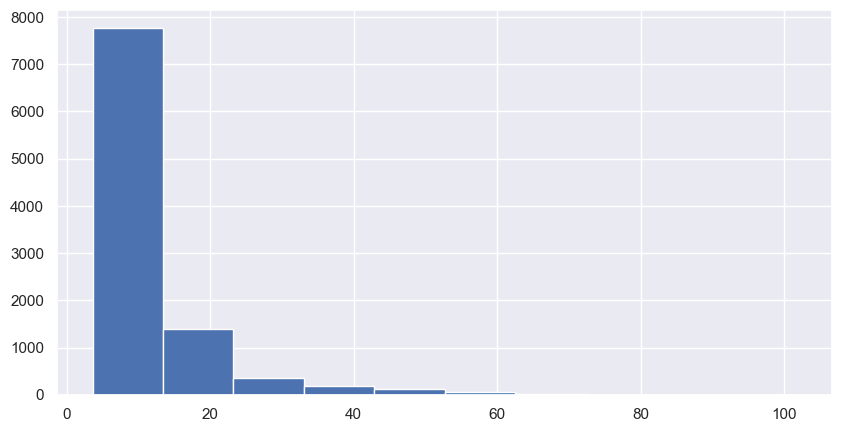

In [ ]:
sub = pd.read_csv('data\sample_submission.csv')
sub['fare_amount'] = clf.predict(test)
sub['fare_amount'] = sub['fare_amount'].abs()
sub['fare_amount'].hist(figsize=(10, 5));
sub

In [ ]:
sub['fare_amount'].min(), sub['fare_amount'].median(), sub['fare_amount'].max()

(3.6110995195156494, 8.73894460535362, 101.81587100297837)

In [ ]:
sub.to_csv('pls.csv', index=False)